# Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a DDGP reinforcement learning algorithm. 

Files in the directory / structure of the project:

- `task.py`: Definition of task (environment) the agent has to learn.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py` 
    - `agent.py`
- `models/`: Folder containing all neural network architectures
    - `networks`: Actor and Critic classes
    - `OUNoise.py`: Class for Ornstein-Uhlenbeck process. 
    - `ReplayBuffer.py`
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

This notebook has three parts

1. Insructions
2. Training & Evaluation of my agent
3. Reflections

## 1. Instructions

For this project, you will define your own task in `task.py`.  You will also design a reinforcement learning agent in `agent.py` to complete your chosen task. You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

### Controlling the Quadcopter (Demonstration)

A very simple sample agent is provided in the code cell below to show how to use the sim to control the quadcopter. The agent controls the quadcopter by setting the revolutions per second on each of its four rotors. 

The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

In [1]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter. (Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.)

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [2]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 50., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

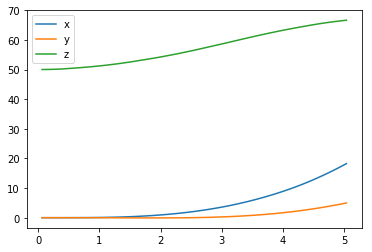

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

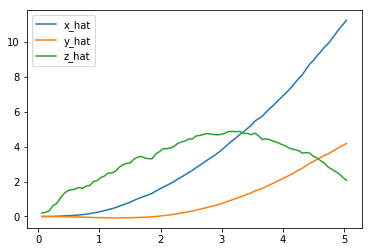

In [4]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

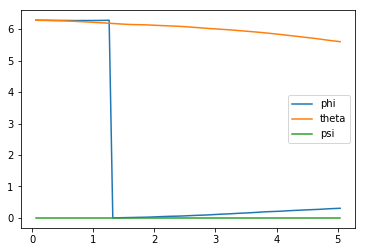

In [5]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

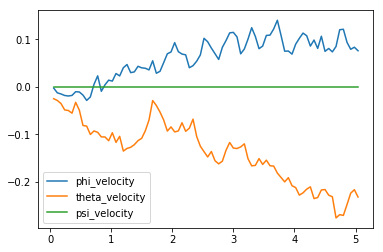

In [6]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

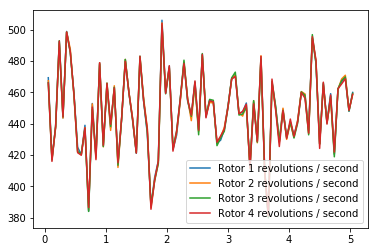

In [7]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [8]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ 18.24799081   4.96494807  66.63073723   0.30628013   5.60275708   0.        ]
[ 11.23333886   4.176854     2.06622184]
[ 0.07591937 -0.23248505  0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

### The Task (Instruction)

A sample task has been provided in `task.py`:

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator. The agent should call this method every time the episode ends. You can see an example of this in the code cell below.

The `step()` method is perhaps the most important. It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

### The Agent (Instruction)

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task. This agent should perform very poorly on this task.  And that's where you come in!

In [9]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 200
target_pos = np.array([0., 0., 50.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    rt_count = 0
    while True:
        rt_count += 1
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, runtime = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, rt_count, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode =  200, runtime =   15, score =   1.579 (best =   1.579), noise_scale = 1.6555

---

## 2. Define the Task, Design  and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [33]:
import sys
import pandas as pd
from agents.agent import DDPG
from task import Task

num_episodes = 1000
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_vel = np.array([0., 0., 0.])         # initial velocities
init_angle_vel = np.array([0., 0., 0.])   # initial angle velocities
target_pos = np.array([0., 0., 60.])

task = Task(init_pose = init_pose, target_pos=target_pos)
agent = DDPG(task) 

# Initializing list for rewards plot
rewards_list = []


for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    loop_count = 0
    while True:
        loop_count += 1
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        

        if done:
            rewards_list.append(agent.score)
            print("\rEpisode = {:4d}, loops = {:4d}, score = {:7.2f} (best = {:7.2f}), pos = {:7.2f} {:7.2f} {:7.2f}".format(
                i_episode, rt_count, agent.score, agent.best_score, 
                task.sim.pose[0], task.sim.pose[1], task.sim.pose[2], end=""))  # [debug]
            break
    sys.stdout.flush()

Episode =    1, loops =   15, score =   39.51 (best =   39.51), pos =  -21.42   -5.81    0.00
Episode =    2, loops =   15, score =   34.56 (best =   39.51), pos =   -8.96  -11.71    0.00
Episode =    3, loops =   15, score =   26.90 (best =   39.51), pos =    8.75  -10.24    0.00
Episode =    4, loops =   15, score =   28.07 (best =   39.51), pos =    5.35    2.17    0.00
Episode =    5, loops =   15, score =   28.69 (best =   39.51), pos =    7.28   -4.33    0.00
Episode =    6, loops =   15, score =   18.97 (best =   39.51), pos =    3.54    4.26    0.00
Episode =    7, loops =   15, score =   20.34 (best =   39.51), pos =    3.91    7.29    0.00
Episode =    8, loops =   15, score =   20.42 (best =   39.51), pos =    4.34    9.27    0.00
Episode =    9, loops =   15, score =   20.87 (best =   39.51), pos =    3.92    9.09    0.00
Episode =   10, loops =   15, score =   19.01 (best =   39.51), pos =    3.96    8.12    0.00
Episode =   11, loops =   15, score =   20.13 (best =   39.5

Episode =   89, loops =   15, score =   27.57 (best =   69.27), pos =    1.88   -9.27    0.00
Episode =   90, loops =   15, score =   22.31 (best =   69.27), pos =   -2.72   -4.71    0.00
Episode =   91, loops =   15, score =   22.59 (best =   69.27), pos =   -5.76   -3.91    0.00
Episode =   92, loops =   15, score =   21.01 (best =   69.27), pos =   -4.41   -6.63    0.00
Episode =   93, loops =   15, score =   20.73 (best =   69.27), pos =   -4.82   -7.79    0.00
Episode =   94, loops =   15, score =   21.79 (best =   69.27), pos =   -4.25   -7.64    0.00
Episode =   95, loops =   15, score =   21.68 (best =   69.27), pos =   -4.08   -8.05    0.00
Episode =   96, loops =   15, score =   20.52 (best =   69.27), pos =   -3.03   -7.43    0.00
Episode =   97, loops =   15, score =   20.04 (best =   69.27), pos =   -2.65   -7.60    0.00
Episode =   98, loops =   15, score =   18.36 (best =   69.27), pos =   -2.86   -9.13    0.00
Episode =   99, loops =   15, score =   19.19 (best =   69.2

Episode =  177, loops =   15, score =   71.28 (best =   71.28), pos =    0.50   15.22   47.80
Episode =  178, loops =   15, score =   61.60 (best =   71.28), pos =   47.53  -67.87   76.53
Episode =  179, loops =   15, score =   32.68 (best =   71.28), pos =    0.27 -150.00    8.47
Episode =  180, loops =   15, score =   34.54 (best =   71.28), pos =   45.22 -150.00   35.72
Episode =  181, loops =   15, score =   29.13 (best =   71.28), pos =   -5.64 -142.38    0.00
Episode =  182, loops =   15, score =   29.96 (best =   71.28), pos =   -9.94  -84.02    0.00
Episode =  183, loops =   15, score =   28.45 (best =   71.28), pos =   -5.99  -39.72    0.00
Episode =  184, loops =   15, score =   28.98 (best =   71.28), pos =   -2.17  -35.72    0.00
Episode =  185, loops =   15, score =   29.26 (best =   71.28), pos =  -10.63 -150.00   12.00
Episode =  186, loops =   15, score =   28.39 (best =   71.28), pos =   -3.21  -53.14    0.00
Episode =  187, loops =   15, score =   34.08 (best =   71.2

Episode =  265, loops =   15, score =   47.05 (best =   85.75), pos =   73.78  -31.96  300.00
Episode =  266, loops =   15, score =   45.10 (best =   85.75), pos =  150.00  -23.02  135.78
Episode =  267, loops =   15, score =   41.33 (best =   85.75), pos =  150.00  -51.67   79.96
Episode =  268, loops =   15, score =   44.42 (best =   85.75), pos =  150.00  -68.27  212.82
Episode =  269, loops =   15, score =   44.12 (best =   85.75), pos =  150.00 -150.00   34.86
Episode =  270, loops =   15, score =   42.42 (best =   85.75), pos =  150.00  -61.22  215.45
Episode =  271, loops =   15, score =   48.92 (best =   85.75), pos =  150.00  -33.91  131.97
Episode =  272, loops =   15, score =   45.37 (best =   85.75), pos =  150.00   -4.85  128.24
Episode =  273, loops =   15, score =   49.74 (best =   85.75), pos =  150.00  -42.20  210.66
Episode =  274, loops =   15, score =   48.22 (best =   85.75), pos =  150.00   -8.99  133.63
Episode =  275, loops =   15, score =   53.95 (best =   85.7

Episode =  353, loops =   15, score =   83.56 (best =  102.74), pos =   30.65  -26.36  138.55
Episode =  354, loops =   15, score =   87.61 (best =  102.74), pos =   28.53   19.39  137.52
Episode =  355, loops =   15, score =   87.46 (best =  102.74), pos =   24.57  -22.35  133.67
Episode =  356, loops =   15, score =   75.11 (best =  102.74), pos =  -65.46   13.75  140.95
Episode =  357, loops =   15, score =   92.53 (best =  102.74), pos =  -26.18    8.74  134.88
Episode =  358, loops =   15, score =   80.51 (best =  102.74), pos =   35.82   24.22  172.88
Episode =  359, loops =   15, score =   69.49 (best =  102.74), pos =  140.93  150.00  300.00
Episode =  360, loops =   15, score =   73.23 (best =  102.74), pos =   13.35   61.41  167.03
Episode =  361, loops =   15, score =   91.79 (best =  102.74), pos =  -14.88  -35.07  130.98
Episode =  362, loops =   15, score =   86.35 (best =  102.74), pos =   24.06   24.66  167.74
Episode =  363, loops =   15, score =   74.40 (best =  102.7

Episode =  441, loops =   15, score =   89.68 (best =  103.05), pos =  -36.06   -0.43  132.11
Episode =  442, loops =   15, score =   88.75 (best =  103.05), pos =   21.08  -17.45  135.21
Episode =  443, loops =   15, score =   90.12 (best =  103.05), pos =   -3.87  -66.64  103.42
Episode =  444, loops =   15, score =   80.66 (best =  103.05), pos =  -13.89  -81.62   82.90
Episode =  445, loops =   15, score =   73.10 (best =  103.05), pos =   53.39   89.62  300.00
Episode =  446, loops =   15, score =   81.42 (best =  103.05), pos =  -65.26  -20.30  107.90
Episode =  447, loops =   15, score =   89.01 (best =  103.05), pos =  -24.98    7.04  137.55
Episode =  448, loops =   15, score =   86.89 (best =  103.05), pos =  -48.33  -17.16  124.26
Episode =  449, loops =   15, score =   97.27 (best =  103.05), pos =   -9.08   12.80  184.72
Episode =  450, loops =   15, score =   84.71 (best =  103.05), pos =  -29.54  -38.96  129.56
Episode =  451, loops =   15, score =   87.38 (best =  103.0

Episode =  529, loops =   15, score =  104.24 (best =  104.30), pos =    1.53    2.89  141.09
Episode =  530, loops =   15, score =   88.30 (best =  104.30), pos =  -34.80   20.17  131.05
Episode =  531, loops =   15, score =   88.72 (best =  104.30), pos =   39.01    9.07  151.32
Episode =  532, loops =   15, score =   79.82 (best =  104.30), pos =  -19.73  -65.23  110.55
Episode =  533, loops =   15, score =   88.24 (best =  104.30), pos =  -54.31   -9.84  121.69
Episode =  534, loops =   15, score =   86.54 (best =  104.30), pos =  -13.21   26.92  166.71
Episode =  535, loops =   15, score =   66.06 (best =  104.30), pos =   69.92   60.60  300.00
Episode =  536, loops =   15, score =   84.97 (best =  104.30), pos =  -24.78  -60.61  108.80
Episode =  537, loops =   15, score =   69.34 (best =  104.30), pos =  -71.26  -62.04   83.04
Episode =  538, loops =   15, score =   76.43 (best =  104.30), pos =  150.00 -150.00  300.00
Episode =  539, loops =   15, score =   79.11 (best =  104.3

Episode =  617, loops =   15, score =   61.11 (best =  104.30), pos =  -43.14  150.00  300.00
Episode =  618, loops =   15, score =   93.71 (best =  104.30), pos =  -13.14  -31.51  131.93
Episode =  619, loops =   15, score =   92.26 (best =  104.30), pos =  -28.71   17.46  138.92
Episode =  620, loops =   15, score =   82.36 (best =  104.30), pos =   22.61  -47.03  131.19
Episode =  621, loops =   15, score =   81.86 (best =  104.30), pos =    7.23   61.37  300.00
Episode =  622, loops =   15, score =   77.43 (best =  104.30), pos =  -58.19  -43.46  107.06
Episode =  623, loops =   15, score =   72.39 (best =  104.30), pos =  -88.36  -21.30   85.81
Episode =  624, loops =   15, score =   83.52 (best =  104.30), pos =  -60.51   13.71  112.85
Episode =  625, loops =   15, score =   75.64 (best =  104.30), pos =   38.76  -68.16  101.01
Episode =  626, loops =   15, score =   77.63 (best =  104.30), pos =   46.43   31.28  300.00
Episode =  627, loops =   15, score =   86.63 (best =  104.3

Episode =  705, loops =   15, score =   86.67 (best =  104.30), pos =   28.87  -53.36  115.51
Episode =  706, loops =   15, score =   73.48 (best =  104.30), pos =   44.57  -37.21  168.42
Episode =  707, loops =   15, score =   93.17 (best =  104.30), pos =  -56.27   -2.35  115.78
Episode =  708, loops =   15, score =   94.78 (best =  104.30), pos =    2.99   16.60  140.09
Episode =  709, loops =   15, score =   63.82 (best =  104.30), pos =  150.00 -150.00   15.54
Episode =  710, loops =   15, score =  102.98 (best =  104.30), pos =   -6.03   -2.26  138.03
Episode =  711, loops =   15, score =   85.95 (best =  104.30), pos =  -14.70  -53.60  121.10
Episode =  712, loops =   15, score =   72.73 (best =  104.30), pos =   70.81  150.00  300.00
Episode =  713, loops =   15, score =   67.07 (best =  104.30), pos =   63.06   33.96  300.00
Episode =  714, loops =   15, score =   87.72 (best =  104.30), pos =  -15.42  -30.83  132.58
Episode =  715, loops =   15, score =   73.21 (best =  104.3

Episode =  793, loops =   15, score =   73.27 (best =  104.30), pos =  150.00   97.18  209.20
Episode =  794, loops =   15, score =   93.11 (best =  104.30), pos =   29.38    6.56  140.80
Episode =  795, loops =   15, score =   93.01 (best =  104.30), pos =    7.62   15.33  165.15
Episode =  796, loops =   15, score =   78.85 (best =  104.30), pos =   32.44  -51.63  120.44
Episode =  797, loops =   15, score =   79.69 (best =  104.30), pos =   12.40 -100.03  159.94
Episode =  798, loops =   15, score =   86.52 (best =  104.30), pos =  -54.38  -10.89  124.81
Episode =  799, loops =   15, score =   81.55 (best =  104.30), pos =    2.99   32.84  198.99
Episode =  800, loops =   15, score =   85.39 (best =  104.30), pos =  -66.32    9.63  107.28
Episode =  801, loops =   15, score =   90.78 (best =  104.30), pos =   26.49   -7.51  139.21
Episode =  802, loops =   15, score =   83.74 (best =  104.30), pos =   18.79  -67.95  109.94
Episode =  803, loops =   15, score =   82.09 (best =  104.3

Episode =  881, loops =   15, score =   80.76 (best =  104.30), pos =  -26.41   32.21  135.65
Episode =  882, loops =   15, score =   86.84 (best =  104.30), pos =    9.17  -54.88  113.06
Episode =  883, loops =   15, score =   87.41 (best =  104.30), pos =   -9.65  -54.52  118.79
Episode =  884, loops =   15, score =   78.96 (best =  104.30), pos =  -50.13  -43.27  112.91
Episode =  885, loops =   15, score =   88.16 (best =  104.30), pos =  -11.80  -68.69  103.21
Episode =  886, loops =   15, score =   86.30 (best =  104.30), pos =  -20.35  -32.86  131.33
Episode =  887, loops =   15, score =   70.32 (best =  104.30), pos =   43.26  -77.94   94.23
Episode =  888, loops =   15, score =   82.88 (best =  104.30), pos =   35.96  -19.29  145.47
Episode =  889, loops =   15, score =   89.63 (best =  104.30), pos =    0.86  -33.06  139.47
Episode =  890, loops =   15, score =   91.84 (best =  104.30), pos =   25.91   10.80  145.51
Episode =  891, loops =   15, score =   99.99 (best =  104.3

Episode =  969, loops =   15, score =   92.80 (best =  104.30), pos =  -32.78  -22.37  128.47
Episode =  970, loops =   15, score =   86.31 (best =  104.30), pos =   -6.74   47.32  294.26
Episode =  971, loops =   15, score =   78.09 (best =  104.30), pos =  -25.91  -85.71   71.62
Episode =  972, loops =   15, score =   99.20 (best =  104.30), pos =  -19.88    5.64  137.00
Episode =  973, loops =   15, score =   97.47 (best =  104.30), pos =   10.55   21.67  163.00
Episode =  974, loops =   15, score =   91.07 (best =  104.30), pos =   -6.48  -33.96  141.07
Episode =  975, loops =   15, score =   81.33 (best =  104.30), pos =  -35.83  -36.46  125.15
Episode =  976, loops =   15, score =   80.78 (best =  104.30), pos =   39.34  -66.53  123.09
Episode =  977, loops =   15, score =   77.95 (best =  104.30), pos =  -43.51   51.33  204.61
Episode =  978, loops =   15, score =   76.50 (best =  104.30), pos =  -27.45  -73.92   96.95
Episode =  979, loops =   15, score =   93.03 (best =  104.3

### Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

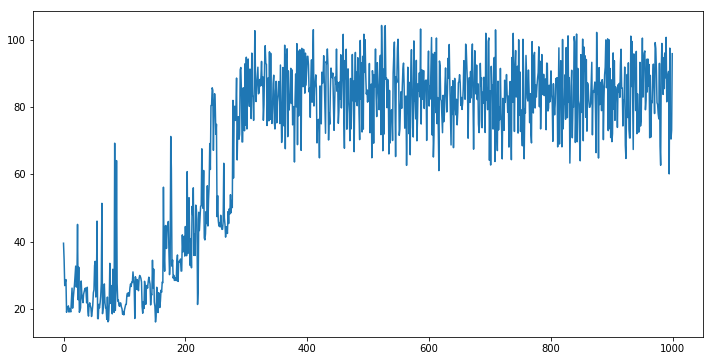

In [34]:
plt.figure(figsize=(12,6))
plt.plot(rewards_list)

### Control The DDPG-Agent

In [35]:
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    state = agent.reset_episode() # start a new episode
    while True:
        rotor_speeds = agent.act(state)
        next_state, reward, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        state = next_state
        if done:
            break

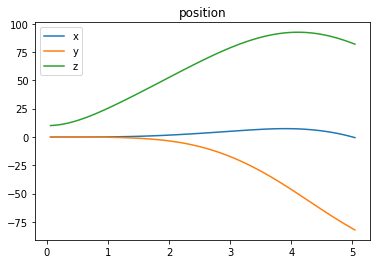

In [36]:
plt.title("position")
plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

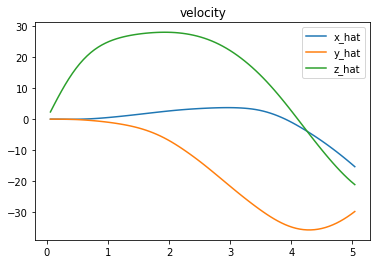

In [37]:
plt.title("velocity")
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

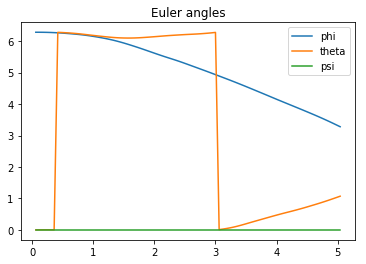

In [38]:
plt.title("Euler angles")
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

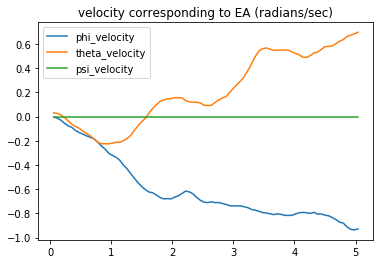

In [39]:
plt.title("velocity corresponding to EA (radians/sec)")
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

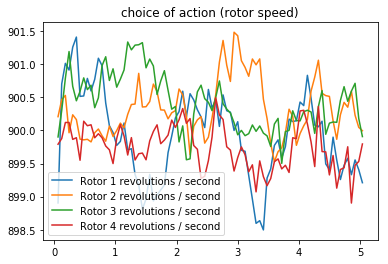

In [40]:
plt.title("choice of action (rotor speed)")
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

## 3. Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**: 
- The task is a vertical take off from position x=0, y=0, z=10 to a target position of x=0, y=0, z=60. First I tried to start from z=0 (from the ground) but that seemed very difficult. Sometimes the agent learnt to take off, but mostly I ended on the ground for 1000 episodes in a row. So I had to lift the starting position a little bit to have consistent success.
- The reward function has two elements, 
    - most important a distance_reward (range -0.8,1), that gets exponentially bigger the more the copter approaches the target 
    - then there is a -1 penalty if the quadcopter is ending on the floor, this to motivate take-off
    

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:
- I worked with the provided DDPG architecture / algorithm. Initially I tried a lot of parameter-tuning and also a different network architecture (less hidden layers, but more nodes) without much succes. I had big problems to get my quadcopter to take off at all or if it did to stay in the air and most of all to produce consistent results over several tries. 

What probably helped to get better and more consistent was (in my opinion) 
- to enlarge the state space so that it includes velocity and angle velocity
- doubling of the size of all hidden layers of both neural nets
- applying BatchNormalization

I changed some hyperparameters too: sigma 0.3 instead of 0.2, tau 0.001 (instead of 0.01), gamma 0.9 (instead of 0.99). The rest of them was not changed.

Actor-architecture:
- 3 dense hidden layers of size 64 - 128 - 64 with relu activation
- final layer with sigmoid activation, which is scaled to fit using a lambda layer
- Adam optimizer, lr 0.0001 (chosen according to DDPG paper)

Critic-architecture:
- 2 paths for state and action, both with 2 dense hidden layers of size 64 - 128 and relu activation 
- paths are then added and passed through another relu activation layer
- final one node layer for producing the Q-values
- Adam optimizer, lr 0.001 (chosen according to DDPG paper)


**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:
- hard, hard, hard ... at least for me ;-). More often than not the quadcopter would not even depart from the ground - or even more frustrating - would fall back and stay at z=0 after a series of good performances not to move again. It took really a lot of tuning to have a more or less stable result in the end.
- gradual - the learning curve of the agent (will say it's rewards curve) is much smoother now, than in earlier versions with smaller neural nets and without batch regularization. Then it was more like rolling a dice sometimes the quadcopter shot up in the air like a rocket but often only to come down again with the same speed. Now it is gently learning every time. // My personal learning experience was very rocky, but in the end I am quite happy with the progress.
- I let training run for 1000 episodes in the last try (see plot). After 350 episodes the progress ended. The quadcopter learnt to take of pretty fast but flies generally to high. Maybe I should try to tweak the reward function in a way to penalize the quadcopter when he is approaching the target area to fast - but that for another time ...

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:
- Getting started was hard at first (where to start?) until I had all the things pierced togehter. Then there was the overwhelming possibilities to tune the parameters / architecture / reward function ... especially the tuning of the reward function was interesting (and also a lot less abstract than tweaking thau, theta or gamma ...)
- One thing I already mentioned earlier: often my agent seemed to forget what he had learned and got stuck on the ground with very low score after having shown a good performance for several dozend episodes. In the end I could stabilize that fortunately. 

---